In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
import numpy as onp
import pandas as pd
from itertools import product
import os

import jax
import jaxlib
from jax import grad, jit, vmap
import jax.numpy as np
import jax.random as random
from jax.experimental import optimizers
from jax.ops import index, index_update
from choicemodels import MultinomialLogit, MultinomialLogitResults
from choicemodels.tools import MergedChoiceTable
from tqdm import tqdm
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

/tmp/ipykernel_3561540/2506435199.py:17: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


In [3]:
jax.config.update('jax_platform_name', 'cpu')

In [4]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [5]:
os.chdir('../scripts')

In [6]:
import compute_pmass as pm
import compute_iter_metrics as cim

import large_mnl as lmnl

In [7]:
num_alts = 200
pop_to_alts_ratio = 750 / 200
num_choosers = int(pop_to_alts_ratio * num_alts)
sample_rates = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0]
scale_params = [.25, .5, .75, 1.0, 1.25, 1.5, 1.75]
coeffs = np.array([-1, 1, 1, 1, 1])

In [ ]:
key = random.PRNGKey(0)
num_iters = 10

keys = random.split(key, num_choosers)
choosers, alts = pm.create_data(num_alts, num_choosers)

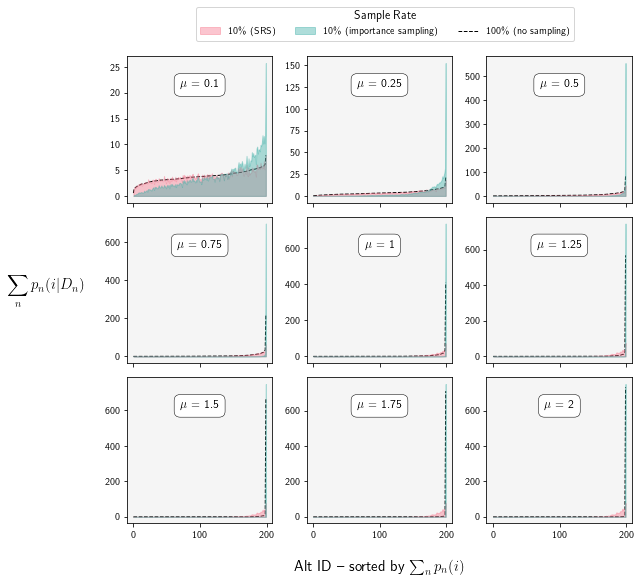

In [150]:
a,b = sns.color_palette("husl", 2)
fig, axarr = plt.subplots(
    3, 3, figsize=(9,7.5),
    sharey=False,
    sharex=True)
for i, scale in enumerate([.1, .25, 0.5, .75, 1, 1.25, 1.5, 1.75, 2]):
    ax = axarr.flatten()[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    
    sorted_idxs = np.argsort(onp.array(results[:,9,:].sum(axis=0)))
#     ax.plot(
#         np.arange(num_alts), onp.array(results[:,0,:].sum(axis=0))[sorted_idxs],
#         c=a,
#         label='10\% (SRS)', lw=1, alpha=0.6)
    ax.fill_between(
        np.arange(num_alts), onp.array(results[:,0,:].sum(axis=0))[sorted_idxs],
        color=a, alpha=0.4, label='10\% (SRS)')
#     ax.plot(
#         np.arange(num_alts), onp.array(results2[:,0,:].sum(axis=0))[sorted_idxs],
#         c=b,
#         label='10\% (importance sampling)', lw=1, alpha=0.6)
    ax.fill_between(np.arange(num_alts), onp.array(results2[:,0,:].sum(axis=0))[sorted_idxs],
                    color=b, alpha=0.4, label='10\% (importance sampling)')
    ax.plot(
        np.arange(num_alts), onp.array(results[:,9,:].sum(axis=0))[sorted_idxs],
        c='k', label='100\% (no sampling)', lw=1, alpha=1, linestyle='--', zorder=0)
#     ax.legend(title='sample rate', fontsize=8, loc='best')
    t = ax.set_title(
        r"$\mu$ = {0}".format(scale), y=.8, x=.5, va='top', fontsize=12, bbox=dict(
            facecolor='white', lw=.5, boxstyle='round,pad=.5')
    )
    ax.set_facecolor("whitesmoke")
    if i == 7:
        ax.set_xlabel("Alt ID -- sorted by $\sum_n p_n(i)$", fontsize=15, va='top', labelpad=20)

    if i == 3:
        ax.set_ylabel("$$\sum_n p_n(i|D_n)$$", rotation='horizontal',
                      labelpad=20,
                      fontsize=15, va='center', ha='right')
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

#     ax.set_yscale("log")

handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(
    handles, labels, loc='lower center', bbox_to_anchor=(.6, 1), title='Sample Rate', ncol=3, title_fontsize=12)
fig.tight_layout()
# fig.supylabel("Probability Massing", x=-.05, fontsize=15, ha='right')

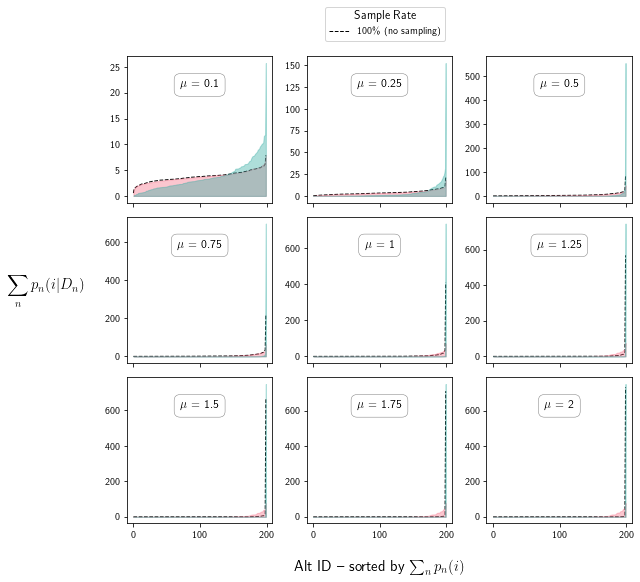

In [145]:
a,b = sns.color_palette("husl", 2)
fig, axarr = plt.subplots(
    3, 3, figsize=(9,7.5),
    sharey=False,
    sharex=True)
for i, scale in enumerate([.1, .25, 0.5, .75, 1, 1.25, 1.5, 1.75, 2]):
    ax = axarr.flatten()[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    
    sorted_idxs = np.argsort(onp.array(results[:,9,:].sum(axis=0)))
#     ax.plot(
#         np.arange(num_alts), onp.array(results[:,0,:].sum(axis=0))[sorted_idxs],
#         c=a,
#         label='10\% (SRS)', lw=1, alpha=0.6)
    ax.fill_between(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))),color=a, alpha=0.4)
#     ax.plot(
#         np.arange(num_alts), onp.array(results2[:,0,:].sum(axis=0))[sorted_idxs],
#         c=b,
#         label='10\% (importance sampling)', lw=1, alpha=0.6)
    ax.fill_between(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))),color=b, alpha=0.4)
    ax.plot(
        np.arange(num_alts), onp.array(results[:,9,:].sum(axis=0))[sorted_idxs],
        c='k', label='100\% (no sampling)', lw=1, alpha=1, linestyle='--', zorder=0)
#     ax.legend(title='sample rate', fontsize=8, loc='best')
    ax.set_title(
        r"$\mu$ = {0}".format(scale), y=.8, x=.5, va='top', fontsize=12, bbox=dict(
            facecolor='none', lw=.5, alpha=.5, boxstyle='round,pad=.5')
    )
    if i == 7:
        ax.set_xlabel("Alt ID -- sorted by $\sum_n p_n(i)$", fontsize=15, va='top', labelpad=20)

    if i == 3:
        ax.set_ylabel("$$\sum_n p_n(i|D_n)$$", rotation='horizontal',
                      labelpad=20,
                      fontsize=15, va='center', ha='right')
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

#     ax.set_yscale("log")

handles, labels = ax.get_legend_handles_labels()
legend = fig.legend(
    handles, labels, loc='lower center', bbox_to_anchor=(.6, 1), title='Sample Rate', ncol=3, title_fontsize=12)
fig.tight_layout()
# fig.supylabel("Probability Massing", x=-.05, fontsize=15, ha='right')

In [376]:
from scipy.stats import ks_2samp, kstest, epps_singleton_2samp as es2
import numpy as np

np.random.seed(12345678)
x = np.random.normal(0, 1, 1000)
y = np.random.normal(0, 1, 1000)
z = np.random.normal(1.1, 0.9, 1000)

print(ks_2samp(x, y))
print(ks_2samp(x, z))
print(es2(x,y))
print(es2(x,z))

KstestResult(statistic=0.023, pvalue=0.9542189106778983)
KstestResult(statistic=0.418, pvalue=1.2040448267583641e-78)
Epps_Singleton_2sampResult(statistic=0.5226462913879119, pvalue=0.9712592436381957)
Epps_Singleton_2sampResult(statistic=680.3683479518411, pvalue=6.206964898874417e-146)


In [397]:
res = pd.DataFrame(columns={'scale', 'sample_rate', 'strategy', 'ks_stat', 'p_val'})
for x in range(10):
    key = random.PRNGKey(x)
    keys = random.split(key, num_choosers)
    choosers, alts = pm.create_data(num_alts, num_choosers)

    for i, scale in enumerate([.1, .25, 0.5, .75, 1, 1.25, 1.5, 1.75, 2]):


        results = vmap(
                        lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                        alts, coeffs, scale, (choosers, keys))

#         results2 = vmap(
#                         lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
#                         alts, coeffs, scale, (choosers, keys))

    #     sorted_idxs = np.argsort(onp.array(results[:,9,:].sum(axis=0)))
        true = onp.array(results2[:,9,:].sum(axis=0))#[sorted_idxs]

        for j, sample_rate in enumerate(sample_rates):
            
            srs = onp.array(results[:,j,:].sum(axis=0))#[sorted_idxs]
            imp = onp.array(results2[:,j,:].sum(axis=0))#[sorted_idxs]

            srs_ks, srs_pval = es2(true, srs)
            imp_ks, imp_pval = es2(true, imp)
            

            tmp_df = pd.DataFrame({
                'scale': [scale, scale], 'sample_rate': [sample_rate, sample_rate],
                'strategy': ['srs', 'importance'], 'ks_stat': [srs_ks, imp_ks],
                'p_val': [srs_pval, imp_pval]

            })
            res = pd.concat((res, tmp_df), ignore_index=True)

    

In [378]:
piv_df = res.pivot_table(index=['sample_rate','scale'], values=['ks_stat','p_val'], columns='strategy')
piv_df.head()

ks_stat                      p_val               
strategy          importance          srs    importance            srs
sample_rate scale                                                     
0.1         0.10   85.348921  3732.260399  1.279219e-17   0.000000e+00
            0.25   85.348921  1352.407390  1.279219e-17  5.488790e-226
            0.50   85.348921   437.167760  1.279219e-17   4.558918e-78
            0.75   85.348921   224.125490  1.279219e-17   3.578218e-39
            1.00   85.348921   151.353015  1.279219e-17   5.171960e-27

In [388]:
data = piv_df['p_val'].reset_index()
data = data[data['sample_rate'] < 1]
data['sample_rate'] = data['sample_rate'].astype(str)

<AxesSubplot:xlabel='srs', ylabel='importance'>

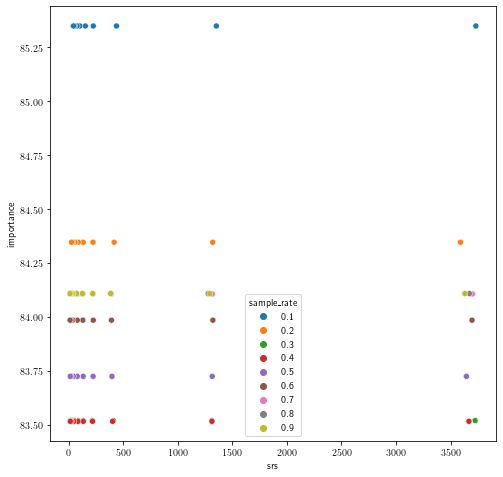

In [381]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=data, x='srs', y='importance', hue='sample_rate', ax=ax)
# ax.set_xlim(0, .8)
# ax.set_ylim(0, .8)

<AxesSubplot:xlabel='sample_rate', ylabel='p_val'>

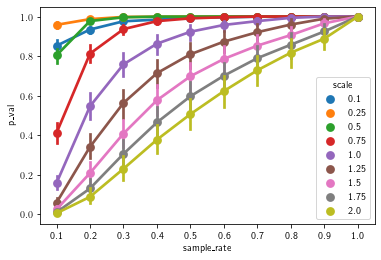

In [353]:
sns.pointplot(data=res[res['strategy'] == 'srs'], x='sample_rate', y='p_val', hue='scale')

<AxesSubplot:xlabel='sample_rate', ylabel='ks_stat'>

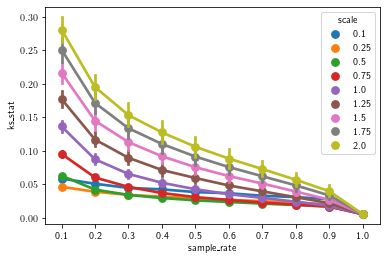

In [356]:
sns.pointplot(data=res[res['strategy'] == 'srs'], x='sample_rate', y='ks_stat', hue='scale')

<AxesSubplot:xlabel='sample_rate', ylabel='ks_stat'>

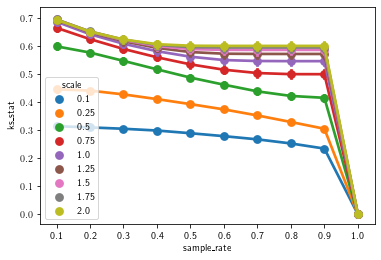

In [355]:
sns.pointplot(data=res[res['strategy'] == 'importance'], x='sample_rate', y='ks_stat', hue='scale')

In [390]:
data = res[res['sample_rate'] == .1]

In [401]:
data = res[res['strategy'] == 'srs']

In [414]:
data[data['scale'] == .5].head(11)

,sample_rate,ks_stat,scale,strategy,p_val
40,0.1,361.547743,0.5,srs,5.629070e-77
42,0.2,300.952138,0.5,srs,6.751771e-64
44,0.3,355.666903,0.5,srs,1.048002e-75
46,0.4,309.204016,0.5,srs,1.119996e-65
48,0.5,314.353450,0.5,srs,8.672777e-67
50,0.6,302.273040,0.5,srs,3.503295e-64
52,0.7,296.990616,0.5,srs,4.829863e-63
54,0.8,296.932193,0.5,srs,4.972058e-63
56,0.9,299.561819,0.5,srs,1.346864e-63
58,1.0,314.417672,0.5,srs,8.400414e-67


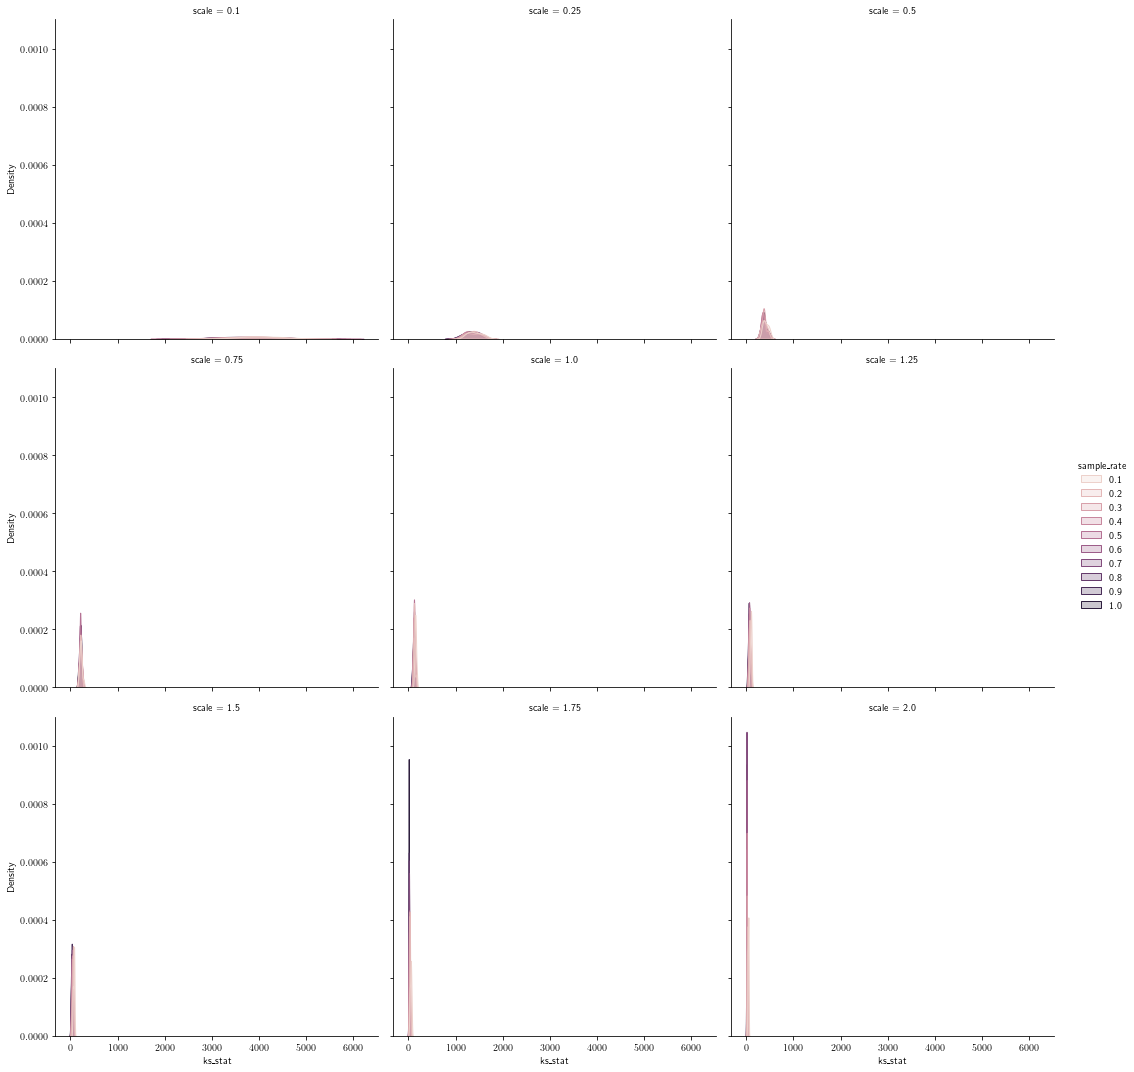

In [415]:
sns.displot(data=data, x='ks_stat', hue='sample_rate', kind='kde', fill=True, col='scale', col_wrap=3)

/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


LinAlgError: singular matrix

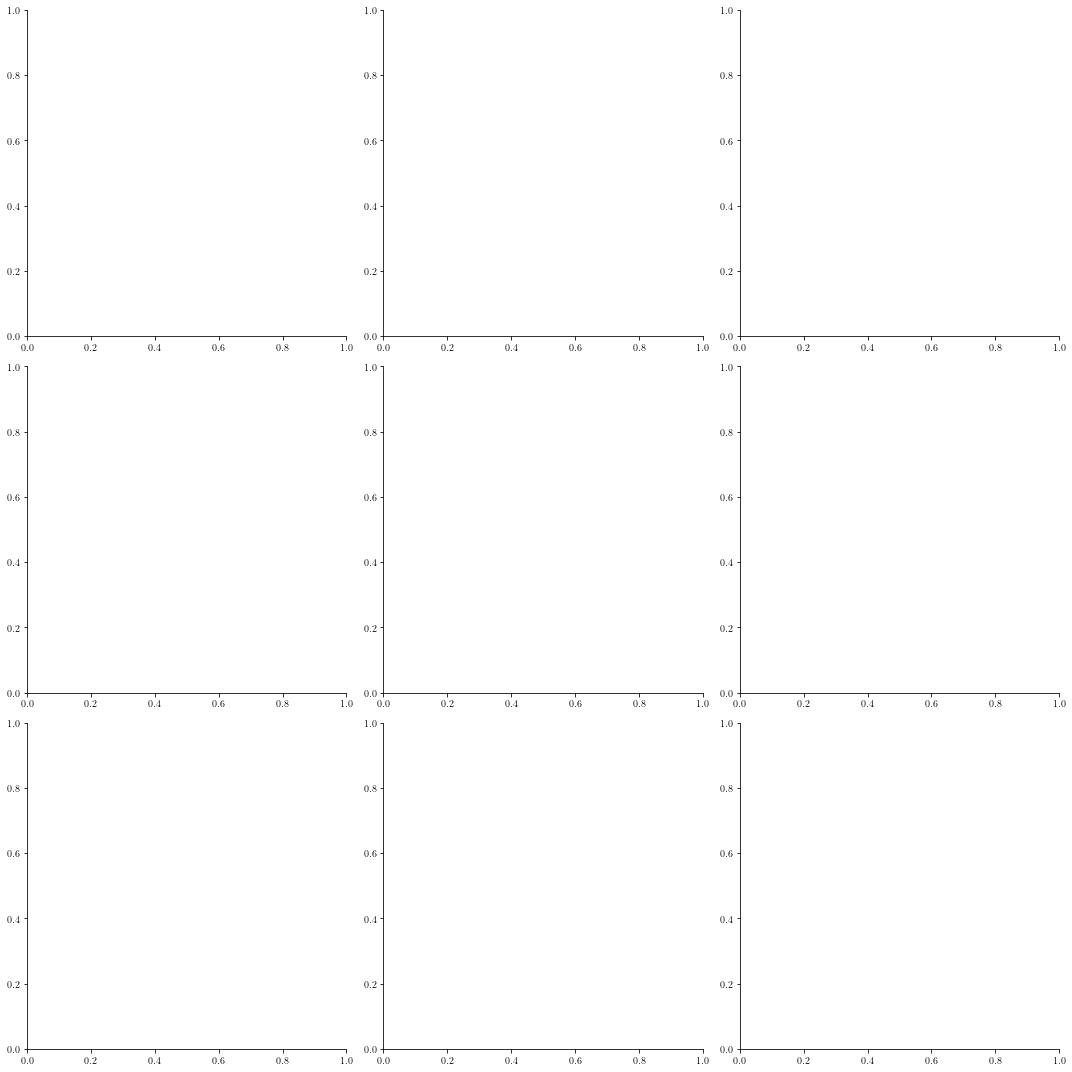

In [393]:
sns.displot(
    data=data, x='p_val', hue='strategy', kind='kde', fill=True, col='scale', col_wrap=3,
    facet_kws={'sharex':False, 'sharey':False})

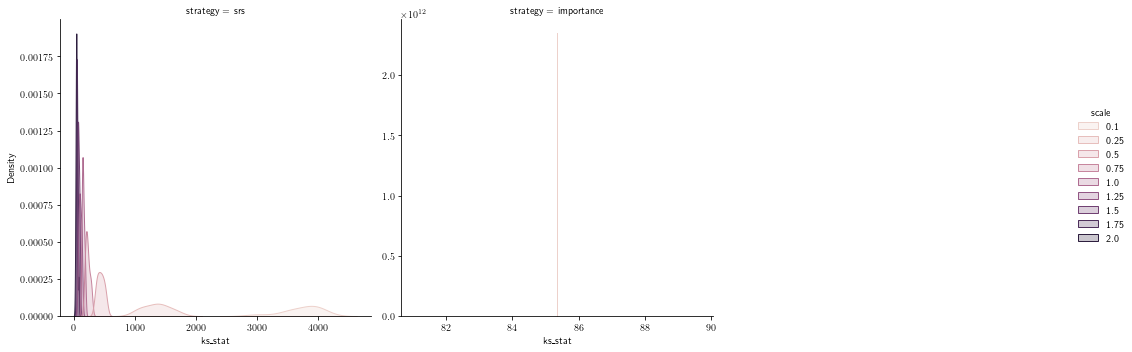

In [391]:
sns.displot(
    data=data, x='ks_stat', hue='scale', kind='kde', fill=True, col='strategy', col_wrap=3,
    facet_kws={'sharex':False, 'sharey':False})

In [311]:
srs = onp.array(results[:,0,:].sum(axis=0))#[sorted_idxs]
imp = onp.array(results2[:,0,:].sum(axis=0))#[sorted_idxs]
true = onp.array(results2[:,9,:].sum(axis=0))#[sorted_idxs]

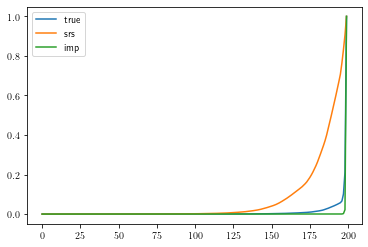

In [315]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_alts),np.sort(true).cumsum() / num_choosers, label='true')
ax.plot(np.arange(num_alts),np.sort(srs).cumsum() / num_choosers, label='srs')
ax.plot(np.arange(num_alts),np.sort(imp).cumsum() / num_choosers, label='imp')
ax.legend()

In [317]:
print(ks_2samp(true, srs))
print(ks_2samp(true, imp))

KstestResult(statistic=0.305, pvalue=1.2940880677508261e-08)
KstestResult(statistic=0.7, pvalue=2.93081659326077e-47)


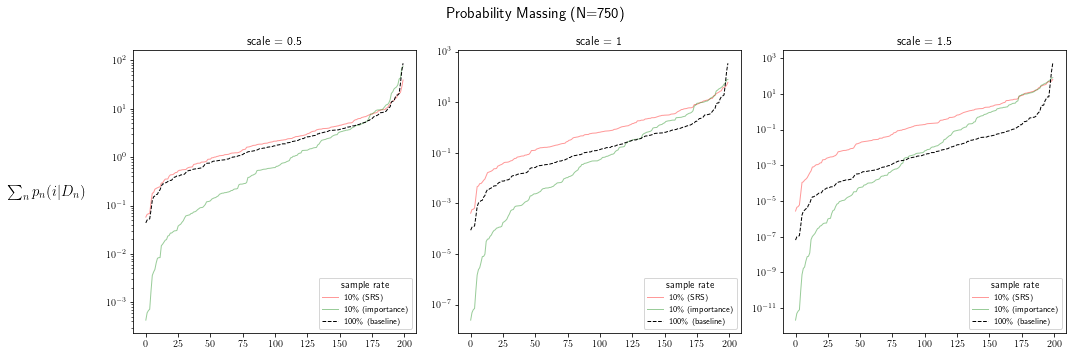

In [38]:
fig, axarr = plt.subplots(1, 3, figsize=(15,5), sharey=False, sharex=True)
for i, scale in enumerate([0.5,  1,  1.5,]):
    ax = axarr.flatten()[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    
    ax.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10\% (SRS)', lw=1, alpha=0.4)
    ax.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10\% (importance)', lw=1, alpha=0.4)
    ax.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='k', label='100\% (baseline)', lw=1, alpha=1, linestyle='--')
    ax.legend(title='sample rate', fontsize=8, loc='lower right')
    ax.set_title("scale = {0}".format(scale))
    if i > 5:
        ax.set_xlabel("Alt ID -- sorted by $\sum_n p_n(i)$", fontsize=12)
    ax.set_yscale("log")
    if i % 3 == 0:
        ax.set_ylabel("$\sum_n p_n(i|D_n)$", rotation='horizontal', labelpad=20, fontsize=15, va='center', ha='right')
fig.suptitle("Probability Massing (N={0})".format(num_choosers), fontsize=15)
fig.tight_layout()

[Text(0, 0, '1'), Text(1, 0, '$$J$$')]

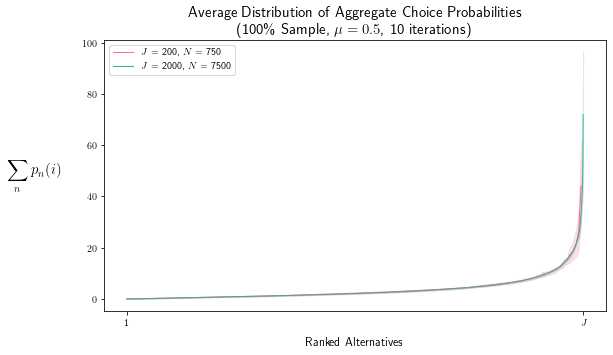

In [75]:
colors = sns.color_palette("husl", 2)
fig, ax = plt.subplots(figsize=(9,5),
    sharey=False,
    sharex=True)

for i, num_alts in enumerate([200, 2000]):
    all_y = []
    all_x = []
    for j in range(10):
        num_choosers = int(pop_to_alts_ratio * num_alts)
        coeffs = np.array([-1, 1, 1, 1, 1])
        key = random.PRNGKey(0)
        num_iters = 10
        keys = random.split(key, num_choosers)
        choosers, alts = pm.create_data(num_alts, num_choosers)
        scale = .5
        results = vmap(
                        lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                        alts, coeffs, scale, (choosers, keys))
        sorted_idxs = np.argsort(onp.array(results[:,9,:].sum(axis=0)))
        y_vals = onp.array(results[:,9,:].sum(axis=0))[sorted_idxs]
        all_y += list(y_vals)
        x_vals = np.arange(num_alts) / num_alts
        all_x += list(x_vals)
    label = r"$J$" + " = {0}, ".format(num_alts) + r"$N$" + " = {0}".format(num_choosers)
    sns.lineplot(
        x=all_x, y=all_y, ci=100,
        color=colors[i], label=label, lw=1, alpha=1, linestyle='-', zorder=0)

ax.legend(loc='upper left')
ax.set_xlabel("Ranked Alternatives", fontsize=12, labelpad=10)
ax.set_ylabel("$$\sum_n p_n(i)$$", labelpad=20, ha='right', va='center', fontsize=15, rotation=0)
ax.set_title("Average Distribution of Aggregate Choice Probabilities\n(100\% Sample, $\mu = 0.5$, 10 iterations)", fontsize=15)
ax.set_xticks([0, 1])
ax.set_xticklabels([1, r"$$J$$"])

In [74]:
onp.array(results[:,9,:].sum(axis=0))[sorted_idxs].std()

5.0767207

In [72]:
np.std(onp.array(results[:,9,:].sum(axis=0))[sorted_idxs] / num_choosers)

DeviceArray(0.0006769, dtype=float32)

In [442]:
from scipy.stats import chisquare, power_divergence, mannwhitneyu

In [25]:
def qqplot(x, y, quantiles=None, interpolation='nearest', ax=None, rug=False,
           rug_length=0.05, rug_kwargs=None, **kwargs):
    """Draw a quantile-quantile plot for `x` versus `y`.

    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.

    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.

    quantiles : int or array-like, optional
        Quantiles to include in the plot. This can be an array of quantiles, in
        which case only the specified quantiles of `x` and `y` will be plotted.
        If this is an int `n`, then the quantiles will be `n` evenly spaced
        points between 0 and 1. If this is None, then `min(len(x), len(y))`
        evenly spaced quantiles between 0 and 1 will be computed.

    interpolation : {‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’}
        Specify the interpolation method used to find quantiles when `quantiles`
        is an int or None. See the documentation for numpy.quantile().

    rug : bool, optional
        If True, draw a rug plot representing both samples on the horizontal and
        vertical axes. If False, no rug plot is drawn.

    rug_length : float in [0, 1], optional
        Specifies the length of the rug plot lines as a fraction of the total
        vertical or horizontal length.

    rug_kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.axvline() and
        matplotlib.axes.Axes.axhline() when drawing rug plots.

    kwargs : dict of keyword arguments
        Keyword arguments to pass to matplotlib.axes.Axes.scatter() when drawing
        the q-q plot.
    """
    # Get current axes if none are provided
    if ax is None:
        ax = plt.gca()

    if quantiles is None:
        quantiles = np.linspace(0, 1, 100) 

    quantiles = onp.atleast_1d(onp.sort(quantiles))
    x_quantiles = onp.quantile(x, quantiles, method=interpolation)
    y_quantiles = onp.quantile(y, quantiles, method=interpolation)

    # Draw the rug plots if requested
    if rug:
        # Default rug plot settings
        rug_x_params = dict(ymin=0, ymax=rug_length, c='gray', alpha=0.5)
        rug_y_params = dict(xmin=0, xmax=rug_length, c='gray', alpha=0.5)

        # Override default setting by any user-specified settings
        if rug_kwargs is not None:
            rug_x_params.update(rug_kwargs)
            rug_y_params.update(rug_kwargs)

        # Draw the rug plots
        for point in x:
            ax.axvline(point, **rug_x_params)
        for point in y:
            ax.axhline(point, **rug_y_params)

    # Draw the q-q plot
    ax.scatter(x_quantiles, y_quantiles, **kwargs)
    
    return ax

In [28]:
qax.get_xlim()[0]

-0.005238368637804685

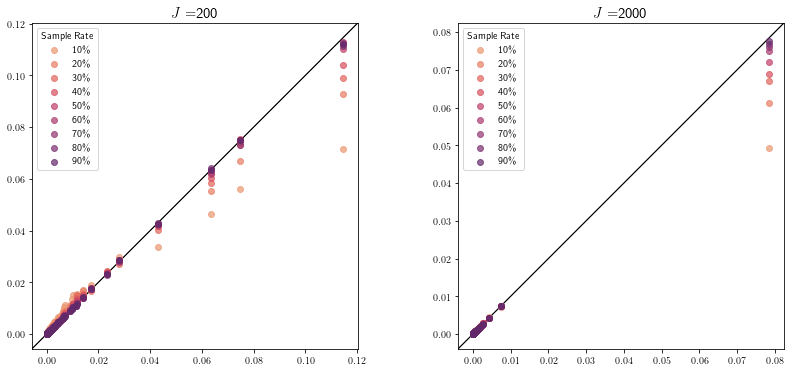

In [41]:
# colors = sns.color_palette("husl", 2)
fig, ax = plt.subplots(1, 2, figsize=(14,6),
    sharey=False,
    sharex=False)
colors = sns.color_palette("flare", 9)

for i, num_alts in enumerate([200, 2000]):
    all_y = []
    all_x = []
    num_choosers = int(pop_to_alts_ratio * num_alts)
    coeffs = np.array([-1, 1, 1, 1, 1])
    key = random.PRNGKey(0)
    num_iters = 10
    keys = random.split(key, num_choosers)
    choosers, alts = pm.create_data(num_alts, num_choosers)
    scale=1
    results = vmap(
        lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
        alts, coeffs, scale, (choosers, keys))
    for j in range(9):
        qax = qqplot(
            onp.array(results[:,9,:].sum(axis=0)) / num_choosers,
            onp.array(results[:,j,:].sum(axis=0)) / num_choosers,
            ax=ax.flatten()[i], label=str(10 * (j + 1)) + '\%', color=colors[j], alpha=0.7)
        qax.legend(title='Sample Rate')
        lims = [
            min(qax.get_xlim()[0], qax.get_ylim()[0]),  # min of both axes
            max(qax.get_xlim()[1], qax.get_ylim()[1]),  # max of both axes
            ]

        # now plot both limits against eachother
        qax.plot(lims, lims, 'k-', lw=.5, alpha=0.75, zorder=0)
        qax.set_aspect('equal')
        qax.set_xlim(lims)
        qax.set_ylim(lims)
    qax.set_title(r"$J=$" + str(num_alts), fontsize=15)

plt.show()

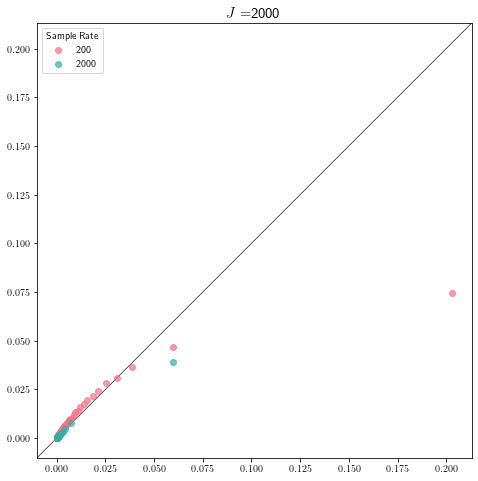

In [48]:
colors = sns.color_palette("husl", 2)
# colors = sns.color_palette("flare", 9)
fig, ax = plt.subplots(figsize=(8,8),
    sharey=False,
    sharex=False)
quantiles = np.linspace(0, 1, 100)

for i, num_alts in enumerate([200, 2000]):
    all_y = []
    all_x = []
    true_qs = []
    samp_qs = [] 
    
    for j in range(10):
        num_choosers = int(pop_to_alts_ratio * num_alts)
        coeffs = np.array([-1, 1, 1, 1, 1])
        key = random.PRNGKey(0)
        num_iters = 10
        keys = random.split(key, num_choosers)
        choosers, alts = pm.create_data(num_alts, num_choosers)
        scale=1
        results = vmap(
            lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
            alts, coeffs, scale, (choosers, keys))

        true_qs.append(onp.quantile(onp.array(results[:,9,:].sum(axis=0)) / num_choosers, quantiles))
        samp_qs.append(onp.quantile(onp.array(results[:,0,:].sum(axis=0)) / num_choosers, quantiles))

    mean_true = np.mean(onp.array(true_qs), axis=0)
    mean_samp = np.mean(onp.array(samp_qs), axis=0)
    qax = qqplot(
        mean_true, mean_samp,
        ax=ax, label=num_alts, color=colors[i], alpha=0.7)

    qax.legend(title='Sample Rate')
    lims = [
        min(qax.get_xlim()[0], qax.get_ylim()[0]),  # min of both axes
        max(qax.get_xlim()[1], qax.get_ylim()[1]),  # max of both axes
        ]

    # now plot both limits against eachother
    qax.plot(lims, lims, 'k-', lw=.5, alpha=0.75, zorder=0)
    qax.set_aspect('equal')
    qax.set_xlim(lims)
    qax.set_ylim(lims)
    qax.set_title(r"$J=$" + str(num_alts), fontsize=15)

plt.show()

In [47]:
onp.array(true_qs).shape

(10, 100)

<AxesSubplot:xlabel='sample_rate', ylabel='pval'>

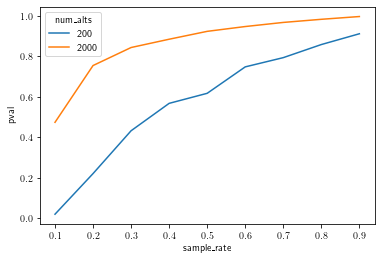

In [450]:
sns.lineplot(data=chi2_df, x='sample_rate', y='pval', hue=chi2_df['num_alts'].astype(str))

In [451]:
from statsmodels.graphics.gofplots import qqplot_2samples

In [452]:
import statsmodels.api as sm

In [456]:
results.shape

(7500, 10, 2000)

In [466]:
pp_x

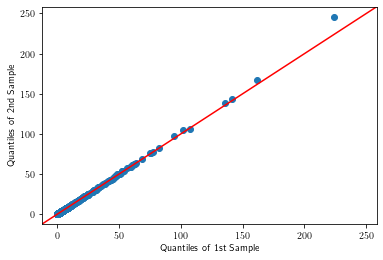

In [465]:
pp_x = sm.ProbPlot(onp.array(results[:,3,:].sum(axis=0)))
pp_y = sm.ProbPlot(onp.array(results[:,9,:].sum(axis=0)))
qqplot_2samples(pp_x, pp_y, line='45')
plt.show()

In [176]:
from scipy.stats import skew, kurtosis

200
mean std:  0.006802636
mean skew:  3.695909448462992
mean kurtosis:  20.39829396688143
2000
mean std:  0.0007202226
mean skew:  5.477589811734521
mean kurtosis:  62.93618691097488


[]

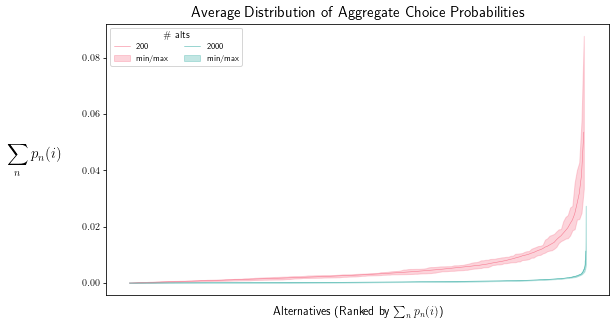

In [117]:
colors = sns.color_palette("husl", 2)
fig, ax = plt.subplots(figsize=(9,5))
num_iters = 25
for i, num_alts in enumerate([200, 2000]):
    print(num_alts)
    all_y = onp.zeros((num_iters, num_alts))
    all_x = onp.arange(num_alts) / num_alts
    all_stds = []
    all_skews = []
    all_kurts = []
    for j in range(num_iters):
        num_choosers = int(pop_to_alts_ratio * num_alts)
        coeffs = np.array([-1, 1, 1, 1, 1])
        key = random.PRNGKey(0)
        num_iters = 10
        keys = random.split(key, num_choosers)
        choosers, alts = pm.create_data(num_alts, num_choosers)
        scale = .5
        results = vmap(
                        lmnl.interaction_probs, in_axes=(None, None, None, 0))(
                        alts, coeffs, scale, choosers)

        sorted_idxs = np.argsort(onp.array(results.sum(axis=0)))
        y_vals = onp.array(results.sum(axis=0))[sorted_idxs] / num_choosers
        all_y[j, :] = list(y_vals)
        all_stds.append(y_vals.std())
        all_skews.append(skew(y_vals))
        all_kurts.append(kurtosis(y_vals))
        
    mean_y = all_y.mean(axis=0)
    print("mean std: ", onp.mean(all_stds))
    print("mean skew: ", onp.mean(all_skews))
    print("mean kurtosis: ", onp.mean(all_kurts))
    ax.plot(
        all_x,
        mean_y,
        color=colors[i], label=num_alts, lw=.5, alpha=1, linestyle='-', )
    ylims = ax.get_ylim()
    max_y = all_y.max(axis=0)
    min_y = all_y.min(axis=0)
    ax.fill_between(all_x, max_y, min_y, color=colors[i], alpha=0.3, label='min/max')


ax.legend(title='\# alts', fontsize=8, loc='upper left', ncol=2)
ax.set_xlabel(r"Alternatives (Ranked by $\sum_n p_n(i)$)", fontsize=12, labelpad=10)
ax.set_ylabel("$$\sum_n p_n(i)$$", labelpad=20, ha='right', va='center', fontsize=15, rotation=0)
ax.set_title(r"Average Distribution of Aggregate Choice Probabilities", fontsize=15)
ax.set_xticks([])
ax.set_xticklabels([])

In [421]:
colors = sns.color_palette("husl", 2)
# fig, ax = plt.subplots(figsize=(8,10))
num_iters = 100
df = pd.DataFrame()
stat_df = pd.DataFrame()
for i, num_alts in enumerate([200, 2000]):
    print(num_alts)
    all_y = onp.zeros((num_iters, num_alts))
    all_x = onp.arange(num_alts) / num_alts
    all_means = []
    all_maxs = []
    all_mins = []
    all_stds = []
    all_skews = []
    all_kurts = []
    all_pmass = []
    for j in range(num_iters):
        num_choosers = int(pop_to_alts_ratio * num_alts)
        coeffs = np.array([-1, 1, 1, 1, 1])
        key = random.PRNGKey(0)
        keys = random.split(key, num_choosers)
        choosers, alts = pm.create_data(num_alts, num_choosers)
        scale = 1
        results = vmap(
                        lmnl.interaction_probs, in_axes=(None, None, None, 0))(
                        alts, coeffs, scale, choosers)

        sorted_idxs = np.argsort(onp.array(results.sum(axis=0)))
        y_vals = onp.array(results.sum(axis=0))[sorted_idxs] / num_choosers
        all_y[j, :] = list(y_vals)
        all_means.append(y_vals.mean())
        all_maxs.append(y_vals.max())
        all_mins.append(y_vals.min())
        all_stds.append(y_vals.std())
        all_skews.append(skew(y_vals))
        all_kurts.append(kurtosis(y_vals))
        if j == 0:
            all_pmass += results.sum(axis=0) / num_choosers
    stat_df = pd.concat((
        stat_df, pd.DataFrame({
            'num_alts': [num_alts] * num_iters,
            'means': all_means,
            'mins': all_mins,
            'maxs': all_maxs,
            'stds': all_stds, 
            'skews': all_skews,
            'kurts': all_kurts})), ignore_index=True)
    df = pd.concat((
        df, pd.DataFrame(
            {'pmass': all_pmass, 'num_alts': [num_alts] * len(all_pmass)})), ignore_index=True)
#     sns.violinplot(x=all_pmass,color=colors[i], label=num_alts, fill=True, alpha=0.5,)
#     sns.rugplot(all_pmass, color=colors[i], label=num_alts,  height=0.025 * (1 + i), alpha=0.5, ax=ax)
    print("mean std: ", onp.mean(all_stds))
    print("mean skew: ", onp.mean(all_skews))
    print("mean kurtosis: ", onp.mean(all_kurts))
# sns.boxplot(y=df['pmass'], x=df['num_alts'].astype(str), width=.5, palette=colors, ax=ax)

# ax.legend(title='\# alts', fontsize=8, loc='best')
# ax.set_xlabel(r"Alternatives (Ranked by $\sum_n p_n(i)$)", fontsize=12, labelpad=10)
# ax.set_ylabel(r"$$\frac{1}{N}\sum_n p_n(i)$$", labelpad=20, ha='right', va='center', fontsize=15, rotation=0)
# ax.set_title(r"Average Distribution of Aggregate Choice Probabilities", fontsize=15)
# ax.set_xticks([])
# ax.set_xticklabels([])

200
mean std:  0.01952603
mean skew:  7.877388707808667
mean kurtosis:  78.02732405357456
2000
mean std:  0.0028957266
mean skew:  19.400914297411447
mean kurtosis:  552.0068359880981


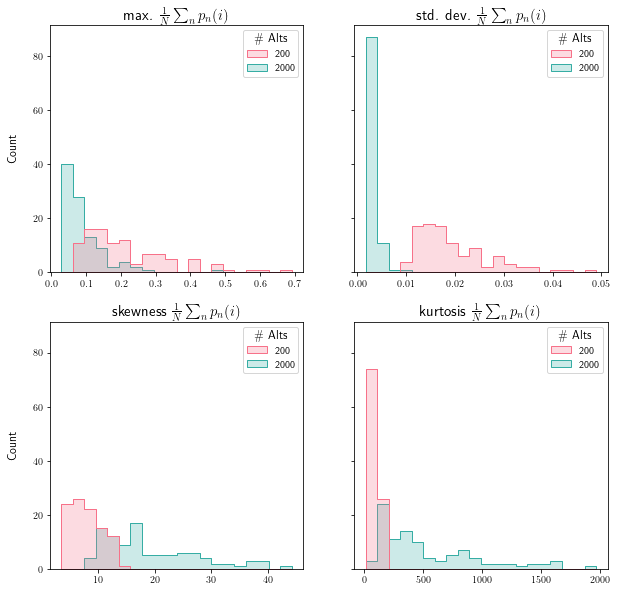

In [422]:
fig, axarr = plt.subplots(2,2, figsize=(10, 10),sharey=True)

metric_cols = ['maxs', 'stds', 'skews', 'kurts']
labels = [r'max. $\frac{1}{N}\sum_n p_n(i)$', r'std. dev. $\frac{1}{N}\sum_n p_n(i)$', r'skewness $\frac{1}{N}\sum_n p_n(i)$', r'kurtosis $\frac{1}{N}\sum_n p_n(i)$']


for i, ax in enumerate(axarr.flatten()):
    g = sns.histplot(
        data=stat_df, x=metric_cols[i], stat='count',
#         kde=True,
        hue='num_alts',
        palette=colors, fill=True, ax=ax, bins=20, element='step')
#     sns.kdeplot(
#         data=stat_df, x=metric_cols[i], hue='num_alts', palette=colors, fill=True, #lw=0,
#         ax=ax, legend=True)
    ax.set_title(labels[i], fontsize=15, )
    ax.set_xlabel("")
#     if i in [0, 2]:
    ax.set_ylabel("Count", fontsize=12, labelpad=15)
#     ax.legend(title='\# Alts')
    legend = g.get_legend()
    legend.set_title("\# Alts")
    plt.setp(legend.get_title(), fontsize=12)
# handles, labels = g.get_legend_handles_labels()
# legend = fig.legend(labels=[200, 2000], loc='upper center', bbox_to_anchor=(.97, .53),title='\# Alts', ncol=1)
# plt.setp(legend.get_title(), fontsize=12)

# fig.suptitle(
#     r"Summary Statistics for $\frac{1}{N}\sum_n p_n(i)$", fontsize=15, y=.95)

In [399]:
legend.set_title('foo')

In [346]:
g.get_legend_handles_labels()

([], [])

In [246]:
ax.get_legend()

<AxesSubplot:xlabel='num_alts', ylabel='kurts'>

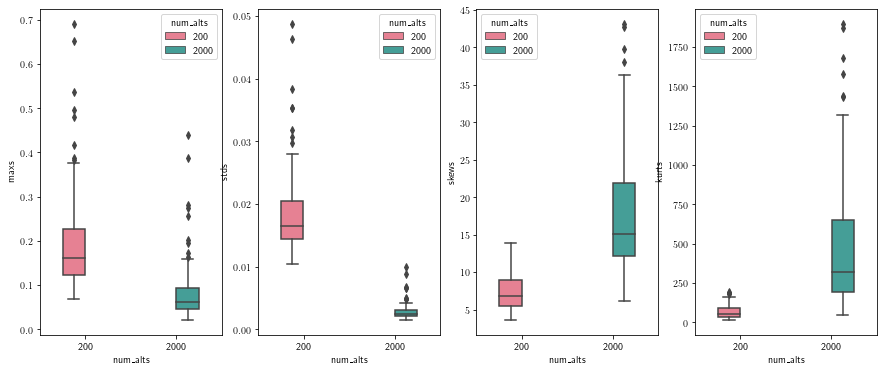

In [281]:
fig, axarr = plt.subplots(1,4, figsize=(15, 6),)
sns.boxplot(
    data=stat_df, y='maxs', x=stat_df['num_alts'].astype(str), hue='num_alts', palette=colors, width=.5, ax=axarr[0])
sns.boxplot(
    data=stat_df, y='stds', x=stat_df['num_alts'].astype(str), hue='num_alts', palette=colors, width=.5, ax=axarr[1])
sns.boxplot(
    data=stat_df, y='skews', x=stat_df['num_alts'].astype(str), hue='num_alts', palette=colors, width=.5, ax=axarr[2])
sns.boxplot(
    data=stat_df, y='kurts', x=stat_df['num_alts'].astype(str), hue='num_alts', palette=colors, width=.5, ax=axarr[3])

Text(0.5, 0.98, 'Cumulative Probability Massing (n=750)')

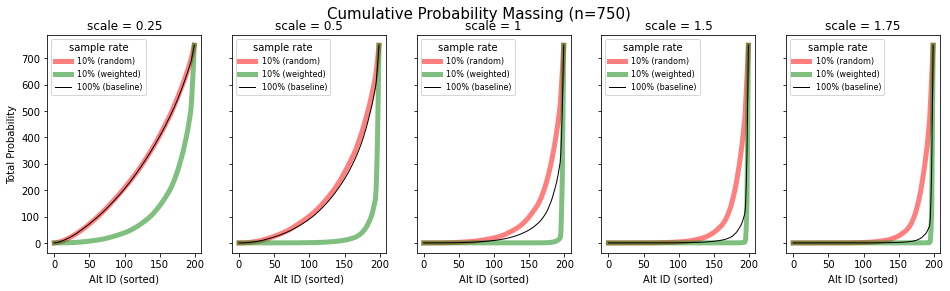

In [89]:
fig, axarr = plt.subplots(1, 5, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.25, 0.5, 1, 1.5, 1.75]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results[:,0,:].sum(axis=0)))), c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results2[:,0,:].sum(axis=0)))), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.sort(onp.array(results[:,9,:].sum(axis=0)))), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID (sorted)")
axarr[0].set_ylabel("Total Probability")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

In [ ]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,0,:].sum(axis=0))) / num_choosers, c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results2[:,0,:].sum(axis=0)) / num_choosers), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,9,:].sum(axis=0)) / num_choosers), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID")
    if scale == 1:
        break
axarr[0].set_ylabel("% Probability Mass")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

Text(0.5, 0.98, 'Cumulative Probability Massing (n=750)')

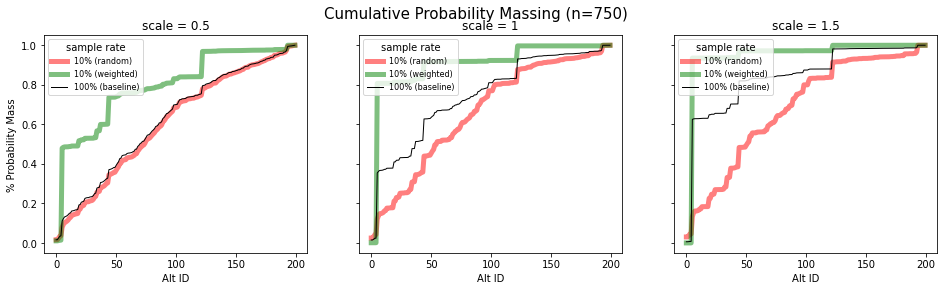

In [15]:
fig, axarr = plt.subplots(1, 3, figsize=(16,4), sharey=True)
for i, scale in enumerate([0.5, 1, 1.5]):
    ax = axarr[i]
    results = vmap(
                    lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))

    results2 = vmap(
                    lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                    alts, coeffs, scale, (choosers, keys))
    

    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,0,:].sum(axis=0))) / num_choosers, c='r', label='10% (random)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results2[:,0,:].sum(axis=0)) / num_choosers), c='g', label='10% (weighted)', lw=5, alpha=0.5)
    ax.plot(np.arange(num_alts), onp.cumsum(onp.array(results[:,9,:].sum(axis=0)) / num_choosers), c='k', label='100% (baseline)', lw=1)
    ax.legend(title='sample rate', fontsize=8, loc='upper left')
    ax.set_title("scale = {0}".format(scale))
    ax.set_xlabel("Alt ID")
axarr[0].set_ylabel("% Probability Mass")
fig.suptitle("Cumulative Probability Massing (n=750)", fontsize=15)

Text(0.5, 1.0, 'scale = 1')

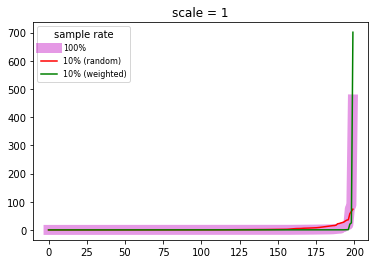

In [16]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 1")

Text(0.5, 1.0, '30% sample')

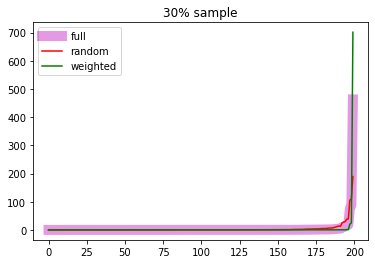

In [20]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

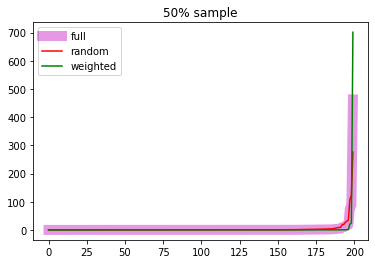

In [21]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")

# Scale = 0.5

In [22]:
results = vmap(
                lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                alts, coeffs, .5, (choosers, keys))

results2 = vmap(
                lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                alts, coeffs, .5, (choosers, keys))

Text(0.5, 1.0, 'scale = 0.5')

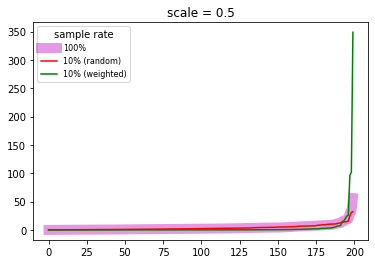

In [23]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 0.5")

Text(0.5, 1.0, '30% sample')

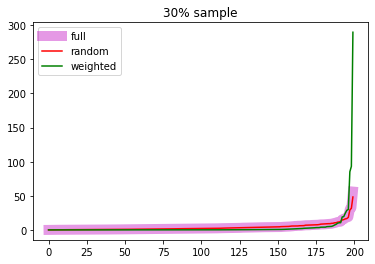

In [24]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

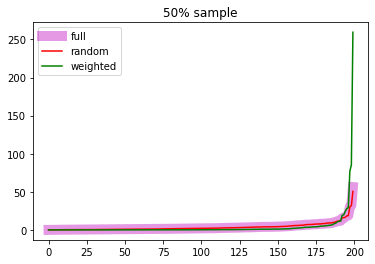

In [25]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")

# Scale 1.5

In [26]:
results = vmap(
                lmnl.interaction_probs_all, in_axes=(None, None, None, 0))(
                alts, coeffs, 1.5, (choosers, keys))

results2 = vmap(
                lmnl.interaction_probs_all_weighted, in_axes=(None, None, None, 0))(
                alts, coeffs, 1.5, (choosers, keys))

Text(0.5, 1.0, 'scale = 1.5')

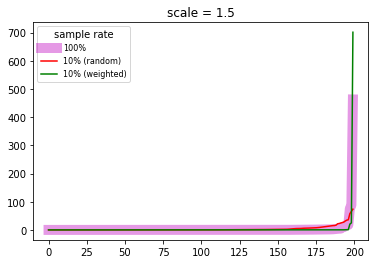

In [27]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='100%', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,0,:].sum(axis=0))), c='r', label='10% (random)')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,0,:].sum(axis=0))), c='g', label='10% (weighted)')
plt.legend(title='sample rate', fontsize=8)
plt.title("scale = 1.5")

Text(0.5, 1.0, '30% sample')

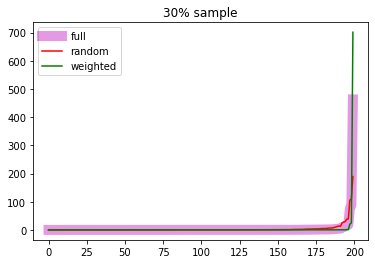

In [28]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,2,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,2,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("30% sample")

Text(0.5, 1.0, '50% sample')

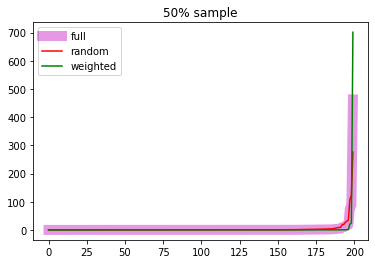

In [29]:
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,9,:].sum(axis=0))), c='m', label='full', lw=10, alpha=0.4)
plt.plot(np.arange(num_alts), np.sort(onp.array(results[:,4,:].sum(axis=0))), c='r', label='random')
plt.plot(np.arange(num_alts), np.sort(onp.array(results2[:,4,:].sum(axis=0))), c='g', label='weighted')
plt.legend()
plt.title("50% sample")